# Pycnocline depth and thickness diagnostics.

A demonstration of pycnocline depth and thickness diagnostics. The first and second depth moments of stratification are computed as proxies for pycnocline depth and thickness, suitable for a nearly two-layer fluid.

### Relevant imports and filepath configuration

In [7]:
import warnings 
warnings.filterwarnings('ignore')

In [8]:
import coast
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors  # colormap fiddling
import xarray as xr

In [9]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly/1950"
fn_nemo_grid_t_dat = f"{data_path}/cv575o_1_mon__grid_T_votemper.nc"
fn_nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"

fn_nemo_grid_t_dat_sal = f"{data_path}/cv575o_1_mon__grid_T_vosaline.nc"
config_t = "../config/example_nemo_grid_t.json"
config_w = "../config/example_nemo_grid_w.json"

### Loading data

In [10]:
infiles = [fn_nemo_grid_t_dat, fn_nemo_grid_t_dat_sal]
# Lazy load data into xarray (only reads data into memory when needed):
t_data = xr.open_mfdataset(infiles)

In [11]:
t_data

<xarray.Dataset> Size: 13GB
Dimensions:              (time_counter: 12, axis_nbounds: 2, deptht: 75,
                          y: 1207, x: 1442, nvertex: 4)
Coordinates:
  * time_counter         (time_counter) object 96B 1950-01-16 00:00:00 ... 19...
  * deptht               (deptht) float32 300B 0.5058 1.556 ... 5.902e+03
  * y                    (y) float64 10kB 0.0 1.0 2.0 ... 1.205e+03 1.206e+03
  * x                    (x) float64 12kB 0.0 1.0 2.0 ... 1.44e+03 1.441e+03
    nav_lat              (y, x) float32 7MB dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    nav_lon              (y, x) float32 7MB dask.array<chunksize=(1207, 1442), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds) object 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bounds        (deptht, axis_nbounds) float32 600B dask.array<chunksize=(75, 2), meta=np.ndarray>
    bounds_nav_lat       (y, x, nvertex) float32 28MB dask.array<chunksize=(604, 721, 2), meta=np.ndarray>
    bounds_nav_lon       (y, x, nvertex) float32 28MB dask.array<chunksize=(604, 721, 2), meta=np.ndarray>
    vosaline             (time_counter, deptht, y, x) float32 6GB dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
    votemper             (time_counter, deptht, y, x) float32 6GB dask.array<chunksize=(1, 19, 302, 361), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    license:                
    institution:            NCAS
    realization_index:      1
    variant_id:             r1i1p2f1
    source_type:            AOGCM
    ...                     ...
    grid:                   Native eORCA025 tripolar primarily 1/4 deg grid; ...
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    realm:                  ocean
    initialization_index:   1
    external_variables:     areacello

### Loading data

In [12]:
# Create a Gridded object and load in the data:

nemo_t = coast.Gridded(t_data, fn_nemo_dom, config=config_t)

In [13]:
# The stratification variables are computed as centred differences of the t-grid variables. 
# These will become w-grid variables. So, create an empty w-grid object, to store stratification. 
# Note how we do not pass a NEMO data file for this load.
nemo_w = coast.Gridded(fn_domain=fn_nemo_dom, config=config_w)


### Subset the domain

We are not interested in the whole doman so it is computationally efficient to subset the data for the region of interest. Here we will look at the North Sea between (51N: 62N) and (-4E:15E).
We will great subset objects for both the t- and w-grids:

In [14]:
ind_2d = nemo_t.subset_indices(start=[51,-4], end=[62,15])
nemo_nwes_t = nemo_t.isel(y_dim=ind_2d[0], x_dim=ind_2d[1])
ind_2d = nemo_w.subset_indices(start=[51,-4], end=[62,15])
nemo_nwes_w = nemo_w.isel(y_dim=ind_2d[0], x_dim=ind_2d[1])
#nemo_nwes_t.dataset # uncomment to print data object summary

In [15]:
# filter data only for some periods for demonstration purposes
nemo_nwes_t = nemo_nwes_t.isel(t_dim=[0,1])

### Diagnostic calculations and plotting 

We can use a COAsT method to construct the in-situ density:


In [16]:
nemo_nwes_t.construct_density( eos='EOS10' )

Then we construct stratification using a COAsT method to take the vertical derivative. Noting that the inputs are on t-pts and the outputs are on w-pt

In [17]:
nemo_nwes_w = nemo_nwes_t.differentiate( 'density', dim='z_dim', out_var_str='rho_dz', out_obj=nemo_nwes_w ) # --> sci_nwes_w.rho_dz


This has created a variable called `nemo_nwes_w.rho_dz`.

###  Create internal tide diagnostics

We can now use the GriddedStratification class to construct the first and second moments (over depth) of density. In the limit of an idealised two-layer fluid these converge to the depth and thickness of the interface. I.e. the pycnocline depth and thickness respectively.

In [18]:
strat = coast.GriddedStratification(nemo_nwes_t)

strat.construct_pycnocline_vars( nemo_nwes_t, nemo_nwes_w, strat_thres=-0.001 )

### Plotting data

Finally we plot pycnocline variables (depth and thickness) using an GriddedStratification method:

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': '16 Jan 1950: masked pycnocline thickness (m)'}, xlabel='longitude', ylabel='latitude'>)

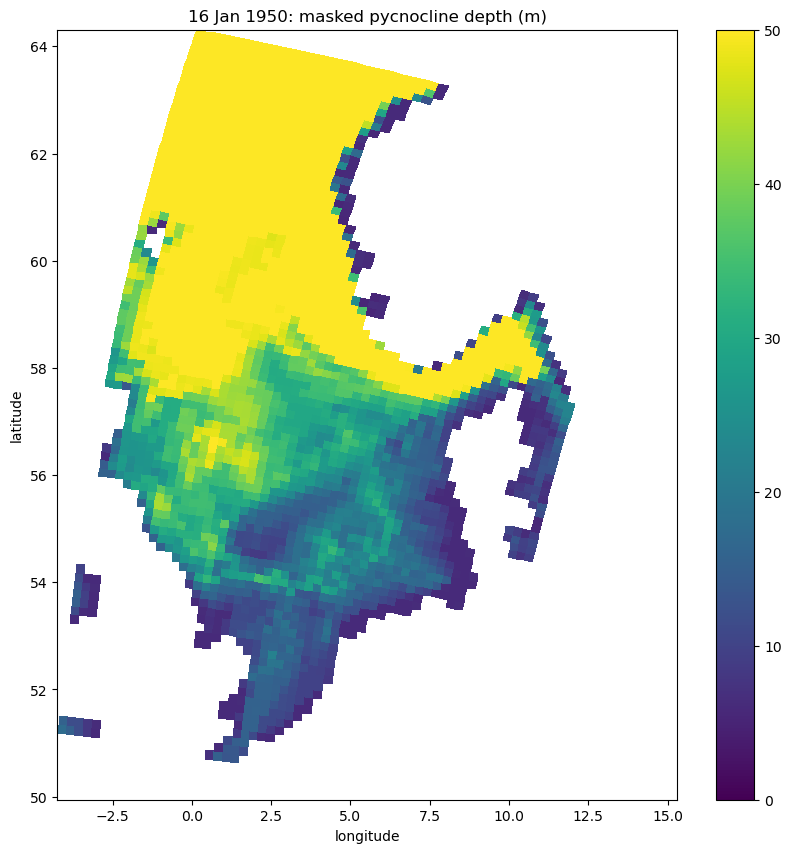

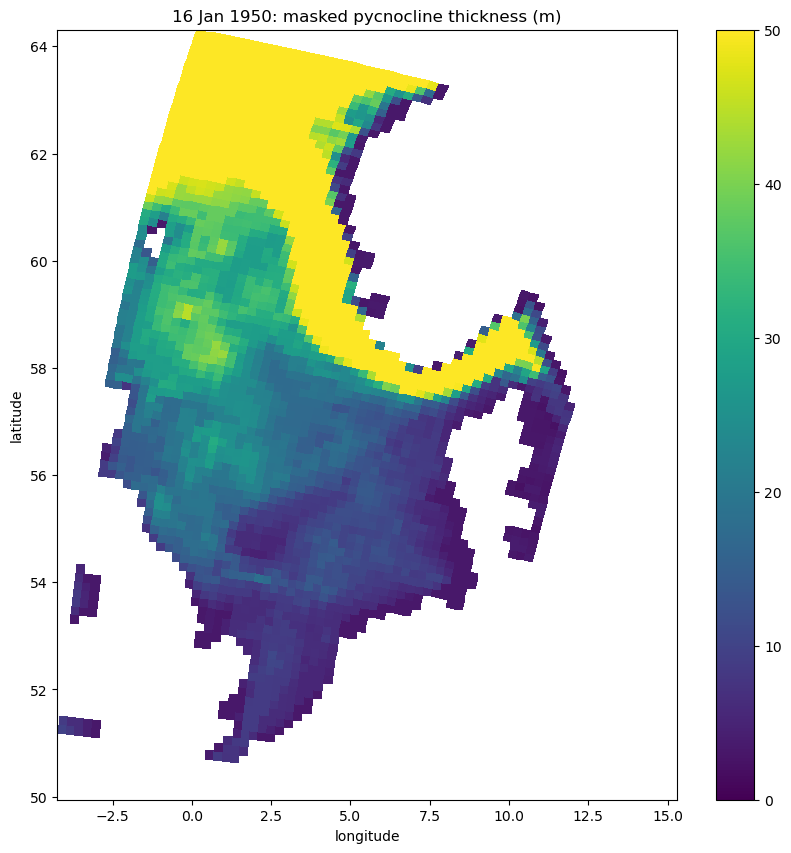

In [19]:
strat.quick_plot()
